# Counterfactual policy simulations

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import funs
import figs
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deduction

In [19]:
LS = {}
GovS = {}
x = np.linspace(0,2,11)

### Single model

In [46]:
SingleEst = SMD.load_est(name='Single')
Single = RetirementClass(**SingleEst)
LS['Single'] = figs.resolve(Single,vars=['d', 'RetAge', 'probs'],fradrag=[0,1])
GovS['Single'] = figs.resolve(Single,vars=['GovS', 'RetAge'],fradrag=x)

### Couple model

In [64]:
CoupleEst,SingleEst = SMD.load_est(name='baseline',couple=True)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
LS['baseline'] = figs.resolve_c(Couple, vars=['d', 'RetAge', 'probs'], fradrag=[0,1])
GovS['baseline'] = figs.resolve_c(Couple, vars=['GovS', 'RetAge'], fradrag=x)

### phi=0

In [5]:
CoupleEst,SingleEst = SMD.load_est(name='phi0',couple=True)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
LS['phi0'] = figs.resolve_c(Couple, vars=['d', 'RetAge', 'probs'], fradrag=[0,1])
GovS['phi0'] = figs.resolve_c(Couple, vars=['GovS', 'RetAge'], fradrag=x)

### phi=0 and finance=0

In [73]:
CoupleEst,SingleEst = SMD.load_est(name='phi0_financial_0',couple=True)
Couple = RetirementClass(couple=True, couple_finance=False, single_kwargs=SingleEst, **CoupleEst)
LS['phi0_f'] = figs.resolve_c(Couple, vars=['d', 'RetAge', 'probs'], fradrag=[0,1])
GovS['phi0_f'] = figs.resolve_c(Couple, vars=['GovS', 'RetAge'], fradrag=x)

### Plots

In [ ]:
figs.GovS_plot(x[1:]*100,[GovS['Single'],GovS['baseline'],GovS['phi0'],GovS['phi0_f']],
               labels=['Singles','Baseline', 'phi=0', 'phi=0,f=0'], fs=15,
               xlab='Deduction (1000 DKR)', ylab='Change per head (billion DKR)',
               N = [Single.par.simN*10, Couple.par.simN*2*10, Couple.par.simN*2*10], 
               change='Abs').savefig('figs/Experiments/DeductionSurplus.png')

In [ ]:
figs.GovS_pct_change_plot(np.arange(1,7),[GovS['baseline'],GovS['Single'],GovS['phi0'],GovS['phi0f']],
               labels=['Singles', 'phi=0', 'phi=0,f=0'], fs=15,
               xlab='Deduction (1000 DKR)', 
               ylab='Percentage difference').savefig('figs/Experiments/DeductionPct.png')

# Retirement age

In [2]:
LS = {}
GovS = {}
age = (65,62,60)
ages_dict_one = {'oap_age':   [i+age[0] for i in range(2)],
                 'two_year':  [i+age[1] for i in range(2)],
                 'erp_age':   [i+age[2] for i in range(2)]}
ages_dict = {'oap_age':   [i+age[0] for i in range(7)],
             'two_year':  [i+age[1] for i in range(7)],
             'erp_age':   [i+age[2] for i in range(7)]}

### Single model

In [3]:
SingleEst = SMD.load_est(name='Single')
Single = RetirementClass(**SingleEst)
LS['Single'] = figs.resolve(Single,vars=['d', 'RetAge', 'probs'],**ages_dict_one)
GovS['Single'] = figs.resolve(Single,vars=['GovS', 'RetAge'],**ages_dict)

### Couple model

In [3]:
CoupleEst,SingleEst = SMD.load_est(name='baseline',couple=True)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
LS['baseline'] = figs.resolve_c(Couple, vars=['d', 'RetAge', 'probs'], **ages_dict_one)
GovS['baseline'] = figs.resolve_c(Couple, vars=['GovS', 'RetAge'], **ages_dict)

### phi=0

In [4]:
CoupleEst,SingleEst = SMD.load_est(name='phi0',couple=True)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
LS['phi0'] = figs.resolve_c(Couple, vars=['d', 'RetAge', 'probs'], **ages_dict_one)
GovS['phi0'] = figs.resolve_c(Couple, vars=['GovS', 'RetAge'], **ages_dict)

### phi=0 and fincance=0

In [5]:
CoupleEst,SingleEst = SMD.load_est(name='phi0_financial0',couple=True)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
LS['phi0_f'] = figs.resolve_c(Couple, vars=['d', 'RetAge', 'probs'], **ages_dict_one)
GovS['phi0_f'] = figs.resolve_c(Couple, vars=['GovS', 'RetAge'], **ages_dict)

### Plots

In [ ]:
figs.GovS_plot(x[1:]*100,[GovS['Single'],GovS['baseline'],GovS['phi0'],GovS['phi0_f']],
               labels=['Singles','Baseline', 'phi=0', 'phi=0,f=0'], fs=15,
               xlab='Increase in retirement age (years)', ylab='Change per head (billion DKR)',
               N = [Single.par.simN*10, Couple.par.simN*2*10, Couple.par.simN*2*10], 
               change='Abs').savefig('figs/Experiments/RASurplus.png')

In [ ]:
figs.GovS_pct_change_plot(np.arange(1,7),[GovS['baseline'],GovS['Single'],GovS['phi0'],GovS['phi0f']],
               labels=['Singles', 'phi=0', 'phi=0,f=0'], fs=15,
               xlab='Increase in retirement age (years)',
               ylab='Percentage difference').savefig('figs/Experiments/RAPct.png')

# Replicate the plot in Jorgensen (2014)

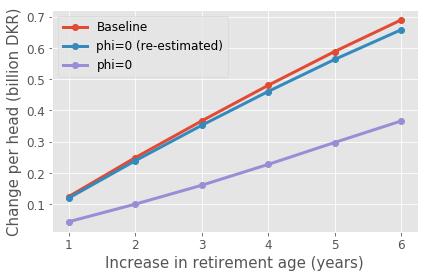

In [7]:
figs.GovS_plot(np.arange(1,7),[GovS['Couple'],GovS['RestCouple'],GovS['phi0']],
               labels=['Baseline', 'phi=0 (re-estimated)', 'phi=0'], fs=15,
               xlab='Increase in retirement age (years)', ylab='Change per head (billion DKR)',
               N = [Couple.par.simN*2*10, Couple.par.simN*2*10, Couple.par.simN*2*10], 
               change='Abs').savefig('figs/Experiments/Thomas.png')

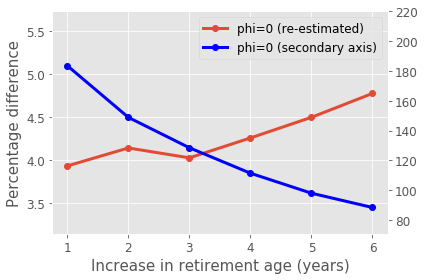

In [10]:
figs.GovS_pct_change_plot(np.arange(1,7),[GovS['Couple'],GovS['RestCouple'],GovS['phi0']],
               labels=['phi=0 (re-estimated)', 'phi=0 (secondary axis)'], fs=15,
               xlab='Increase in retirement age (years)', 
               ylab='Percentage difference').savefig('figs/Experiments/ThomasPct.png')

However note the difference in the overall average retirement age

In [9]:
print('Baseline model        :', np.round(LS['Couple']['RetAge'][0]['base'],2))
print('phi=0 (re-estimated)  :', np.round(LS['RestCouple']['RetAge'][0]['base'],2))
print('phi=0                 :', np.round(LS['phi0']['RetAge'][0]['base'],2))

Baseline model        : 61.67
phi=0 (re-estimated)  : 61.67
phi=0                 : 64.65
